In [1]:
# 1. install kaggle package
!pip install kaggle

# 2. move kaggle.json (upload via Colab UI or mount from Drive)
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 3. Download dataset (use the dataset slug)
!kaggle datasets download -d puneet6060/intel-image-classification



Dataset URL: https://www.kaggle.com/datasets/puneet6060/intel-image-classification
License(s): copyright-authors
 90% 313M/346M [00:00<00:00, 794MB/s] 
100% 346M/346M [00:00<00:00, 749MB/s]


In [3]:
# 4. Unzip|
!unzip intel-image-classification.zip -d dataset

Streaming output truncated to the last 5000 lines.
  inflating: dataset/seg_train/seg_train/mountain/7506.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7537.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7539.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7551.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7560.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7565.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7578.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7581.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7586.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7647.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7652.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7654.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7662.jpg  
  inflating: dataset/seg_train/seg_train/mountain/767.jpg  
  inflating: dataset/seg_train/seg_train/mountain/7672.jpg  
  inflating: dataset/seg_train/seg_

In [4]:

# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import zipfile
import shutil
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Deep learning imports
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.model_selection import train_test_split


In [7]:
base_dir = '/content/dataset/seg_train/seg_train'
test_dir = '/content/dataset/seg_test/seg_test'
pred_dir = '/content/dataset/seg_pred/seg_pred'

In [8]:
classes = sorted(os.listdir(base_dir))
print(f"\nClasses found: {classes}")
print(f"Number of classes: {len(classes)}")



Classes found: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
Number of classes: 6


In [9]:
class_counts = {}
all_image_paths = []
all_labels = []

for class_name in classes:
    class_path = os.path.join(base_dir, class_name)
    images = os.listdir(class_path)
    class_counts[class_name] = len(images)

    for img_name in images:
        all_image_paths.append(os.path.join(class_path, img_name))
        all_labels.append(class_name)

In [10]:
for class_name, count in class_counts.items():
    print(f"{class_name:15s}: {count:5d} images")
print(f"{'TOTAL':15s}: {sum(class_counts.values()):5d} images")

buildings      :  2191 images
forest         :  2271 images
glacier        :  2404 images
mountain       :  2512 images
sea            :  2274 images
street         :  2382 images
TOTAL          : 14034 images


In [11]:
test_classes = sorted(os.listdir(test_dir))
test_counts = {}
for class_name in test_classes:
    test_path = os.path.join(test_dir, class_name)
    test_counts[class_name] = len(os.listdir(test_path))


In [12]:
for class_name, count in test_counts.items():
    print(f"{class_name:15s}: {count:5d} images")
print(f"{'TOTAL':15s}: {sum(test_counts.values()):5d} images")

buildings      :   437 images
forest         :   474 images
glacier        :   553 images
mountain       :   525 images
sea            :   510 images
street         :   501 images
TOTAL          :  3000 images


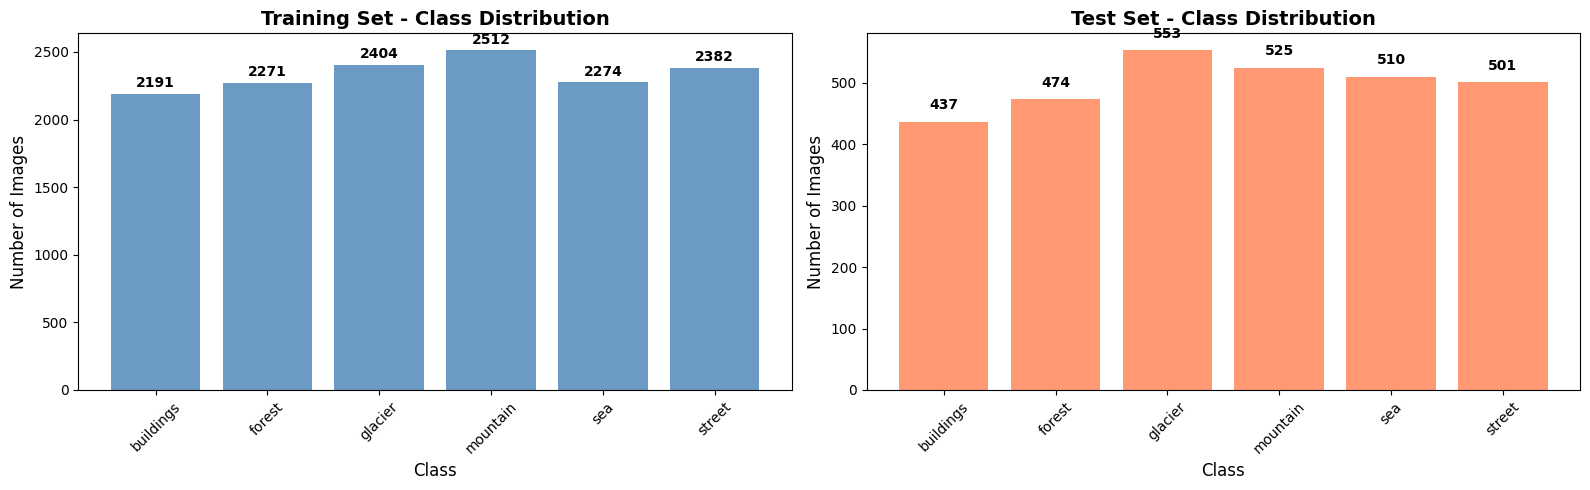

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Training set distribution
axes[0].bar(class_counts.keys(), class_counts.values(), color='steelblue', alpha=0.8)
axes[0].set_title('Training Set - Class Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(class_counts.items()):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Test set distribution
axes[1].bar(test_counts.keys(), test_counts.values(), color='coral', alpha=0.8)
axes[1].set_title('Test Set - Class Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
for i, (k, v) in enumerate(test_counts.items()):
    axes[1].text(i, v + 20, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

THAT Proves that the classes are well balanced

In [17]:
# Load sample image to get dimensions
sample_img_path = all_image_paths[0]
sample_img = Image.open(sample_img_path)
img_width, img_height = sample_img.size
print(f"Width: {img_width}px, Height: {img_height}px")



Width: 150px, Height: 150px


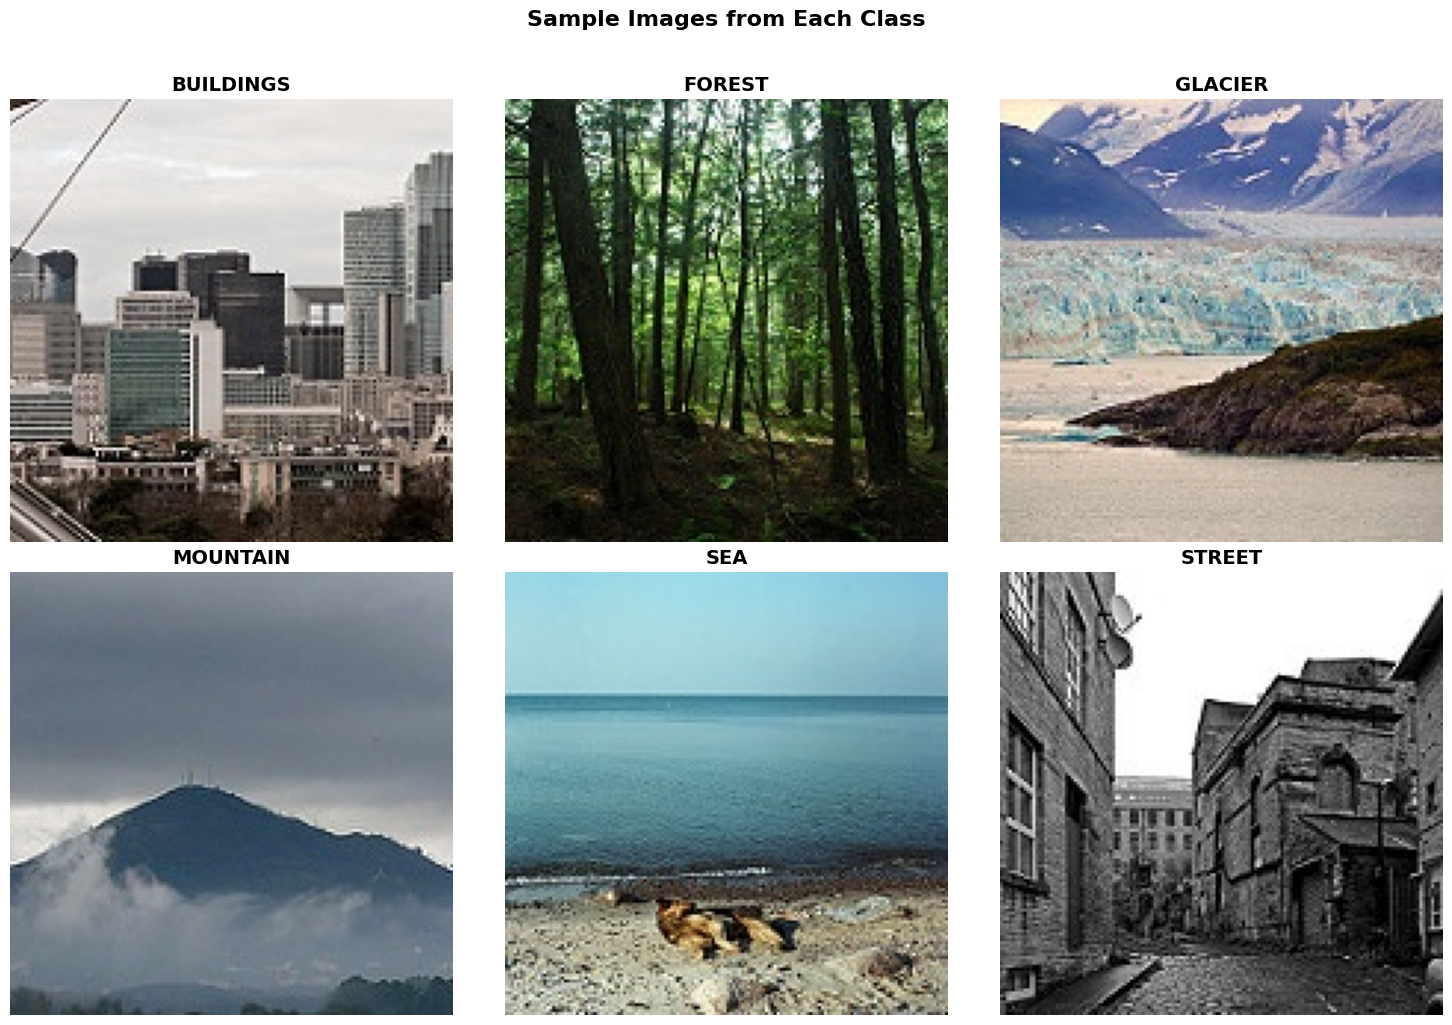

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()

for idx, class_name in enumerate(classes):
    class_path = os.path.join(base_dir, class_name)
    sample_images = os.listdir(class_path)[:1]

    img_path = os.path.join(class_path, sample_images[0])
    img = Image.open(img_path)

    axes[idx].imshow(img)
    axes[idx].set_title(f'{class_name.upper()}', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Sample Images from Each Class', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

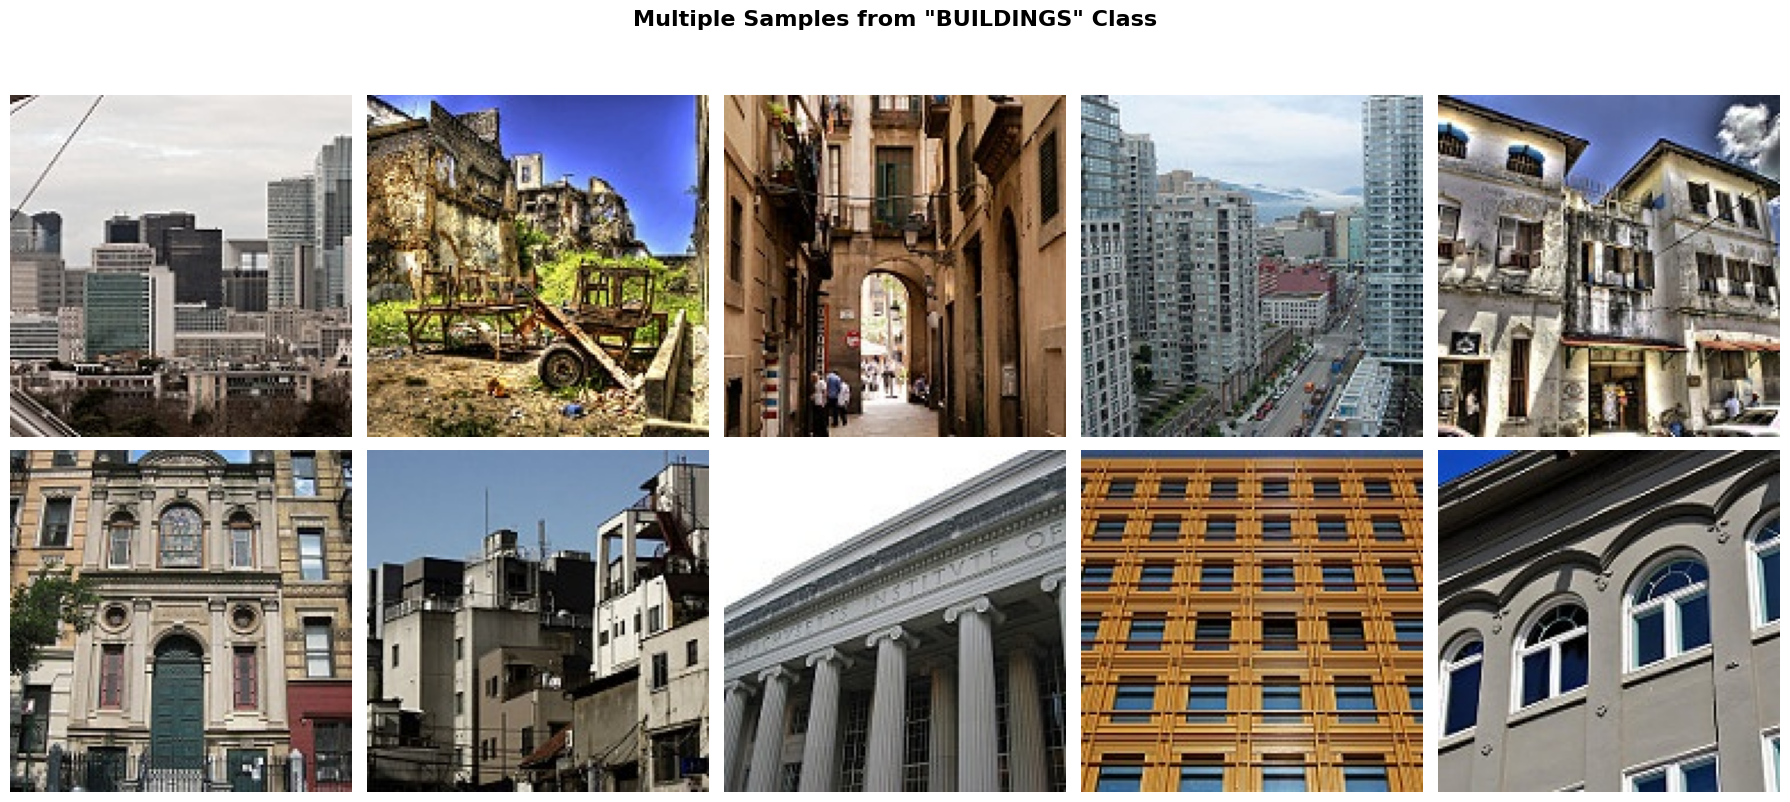

In [19]:
fig, axes = plt.subplots(2, 5, figsize=(18, 8))
axes = axes.ravel()

sample_class = classes[0]
class_path = os.path.join(base_dir, sample_class)
sample_images = os.listdir(class_path)[:10]

for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(class_path, img_name)
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')

plt.suptitle(f'Multiple Samples from "{sample_class.upper()}" Class',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [21]:
# Create DataFrame
df = pd.DataFrame({
    'filepath': all_image_paths,
    'label': all_labels
})

# First split: 70% train, 30% temp (which will be split into 15% val, 15% test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.3,
    stratify=df['label'],
    random_state=42
)

# Second split: Split temp into 50% validation, 50% test (each 15% of total)
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df['label'],
    random_state=42
)

In [23]:
print(f"\nTraining samples: {len(train_df)}")
print(f"Validation samples: {len(val_df)} ")
print(f"Test samples: {len(test_df)} ")



Training samples: 9823
Validation samples: 2105 
Test samples: 2106 


In [24]:
IMG_SIZE = (150, 150)
BATCH_SIZE = 32

In [26]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [28]:
# Create generators using flow_from_dataframe
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

validation_generator = val_test_datagen.flow_from_dataframe(
    val_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = val_test_datagen.flow_from_dataframe(
    test_df,
    x_col='filepath',
    y_col='label',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 9823 validated image filenames belonging to 6 classes.
Found 2105 validated image filenames belonging to 6 classes.
Found 2106 validated image filenames belonging to 6 classes.


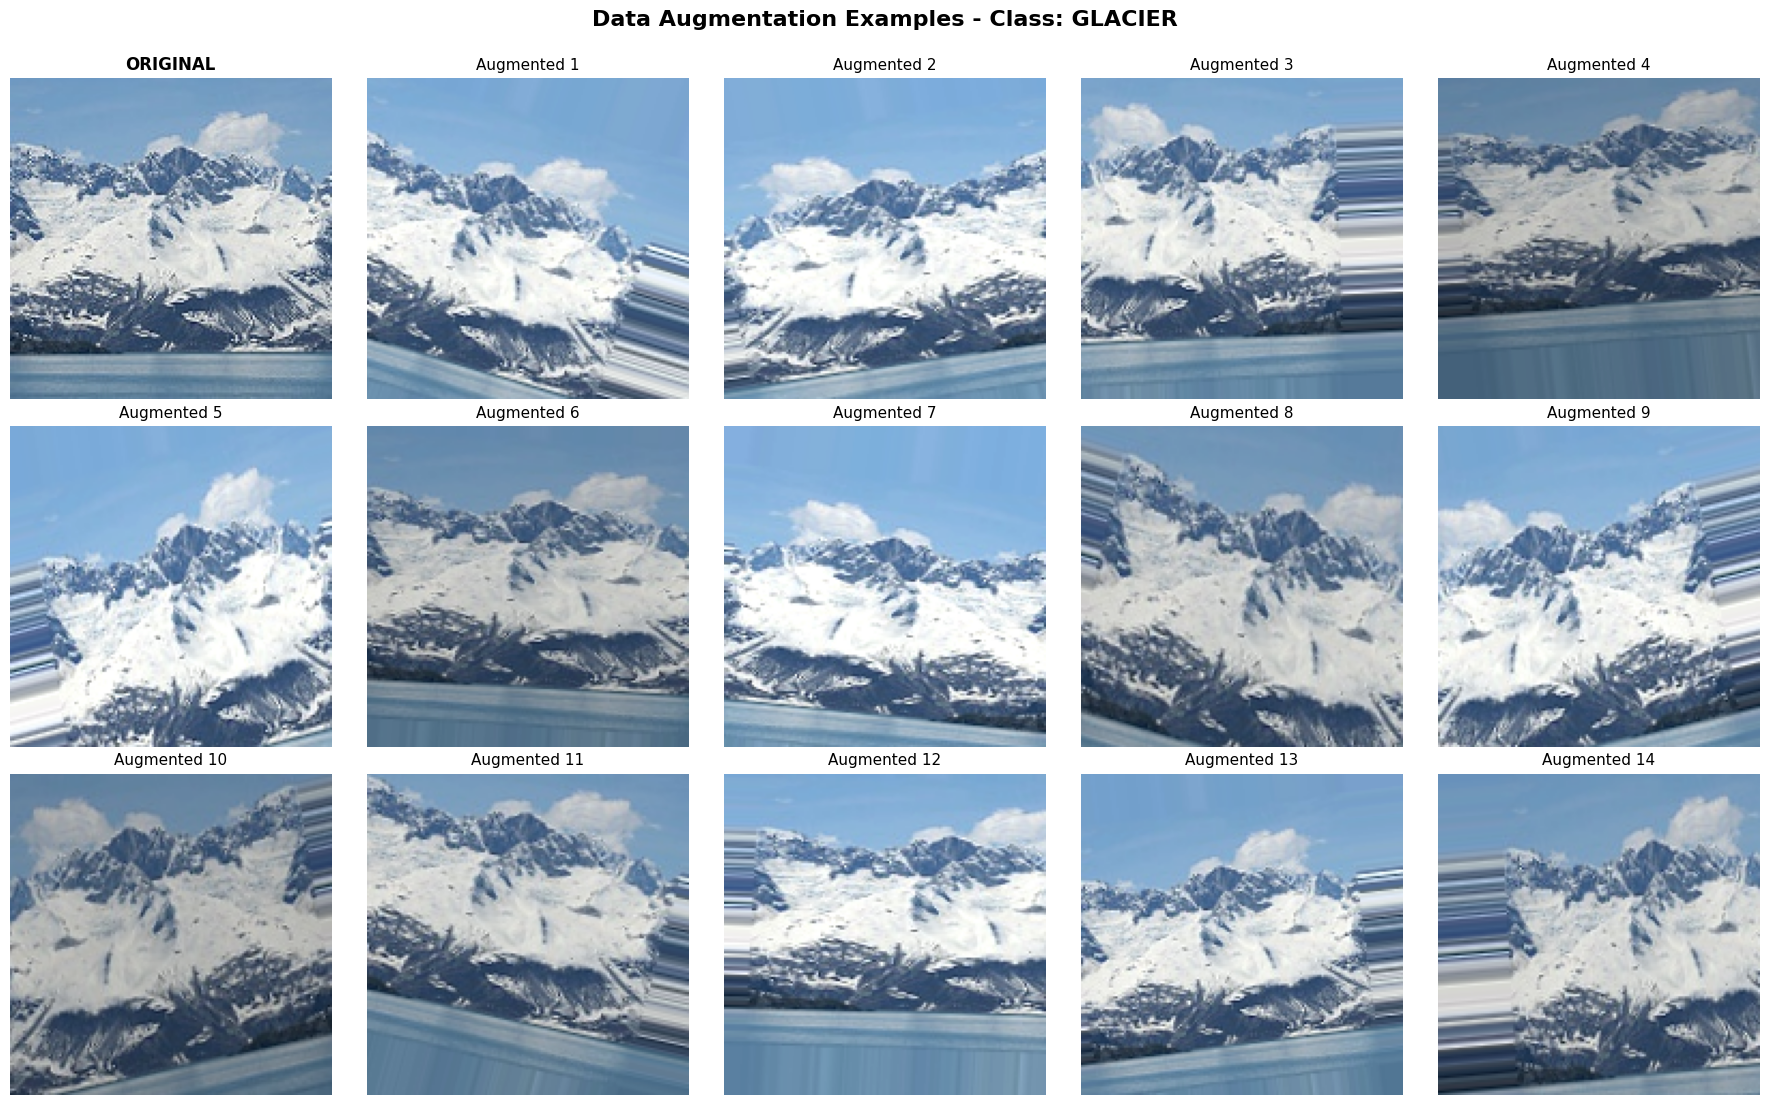

In [30]:
# Get a sample image
sample_img_path = train_df.iloc[100]['filepath']
sample_label = train_df.iloc[100]['label']
img = load_img(sample_img_path, target_size=IMG_SIZE)
x = img_to_array(img)
x = x.reshape((1,) + x.shape)

# Generate augmented samples
fig, axes = plt.subplots(3, 5, figsize=(18, 11))
axes = axes.ravel()

# Show original
axes[0].imshow(img)
axes[0].set_title('ORIGINAL', fontweight='bold', fontsize=12)
axes[0].axis('off')

# Generate and show augmented versions
i = 1
for batch in train_datagen.flow(x, batch_size=1):
    axes[i].imshow(batch[0])
    axes[i].set_title(f'Augmented {i}', fontsize=11)
    axes[i].axis('off')
    i += 1
    if i >= 15:
        break

plt.suptitle(f'Data Augmentation Examples - Class: {sample_label.upper()}',
             fontsize=16, fontweight='bold', y=1.0)
plt.tight_layout()
plt.show()